# Introduction

# Setting up the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files

# Upload your Kaggle API token JSON file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:31<00:00, 123MB/s]
100% 3.10G/3.10G [00:31<00:00, 105MB/s]


In [5]:
!ls

breast-histopathology-images.zip  drive  kaggle.json  sample_data


In [6]:
!unzip -q breast-histopathology-images.zip -d dataset

## Importing modules

In [7]:
# Basic libraries
import numpy as np
import random
from os import listdir
from PIL import Image

# Preprocessing/Visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical

# Model creation
import tensorflow as tf
import keras
from keras import layers

# Evaluatiom
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [8]:
# Defining directories

base_path = "dataset/IDC_regular_ps50_idx5/"
files = listdir(base_path)

# Length of the samples is usually the no of patients

print("Total no of patients: "+ str(len(files)))

Total no of patients: 279


In [9]:
# Saving the data source into an array

dataset = []

for i in range(len(files)):
  patient_id = files[i]
  for c in [0,1]:
    patientid_path = base_path + patient_id
    class_path = patientid_path + "/" + str(c) + "/"
    samples = listdir(class_path)
    for picture in samples:
      image_path = class_path + picture
      dataset.append([image_path, c])

In [10]:
print("No. of images: " + str(len(dataset)))

No. of images: 277524


In [11]:
dataset[0]

['dataset/IDC_regular_ps50_idx5/9258/0/9258_idx5_x2701_y601_class0.png', 0]

In [12]:
limit = len(dataset) / 6
dataset = dataset[:int(limit)]

len(dataset)

46254

In [13]:
# Data Visualization

# Load an image

image_path = dataset[0][0]
label = dataset[0][1]
image = Image.open(image_path)

# Dimensions of the image
print("Width and height respectively: " + str(image.size) + " Pixels")

Width and height respectively: (50, 50) Pixels


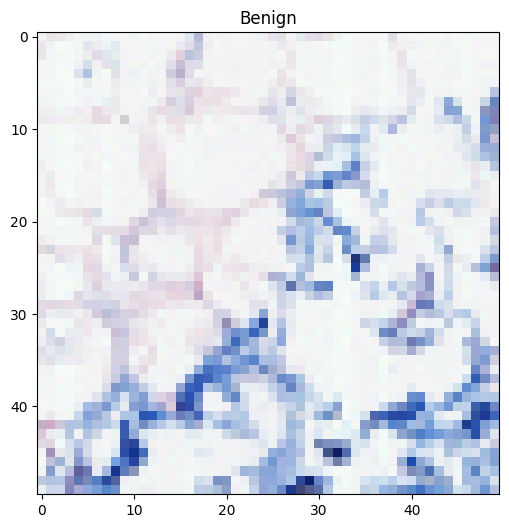

In [14]:
# Show the first image in the dataset

plt.figure(figsize=(6, 6))

plt.imshow(image)
plt.title("Benign")

plt.show()

In [15]:
# Seperate the data by class

BENIGNdata = [img for img, label in dataset if label == 0]
MALIGNANTdata = [img for img, label in dataset if label == 1]

BENIGNlabels = [label for img, label in dataset if label == 0]
MALIGNANTlabels = [label for img, label in dataset if label == 1]

In [16]:
# Get a sample of images each type of dataset

BENIGNsample = random.sample(BENIGNdata, 50)
MALIGNANTsample = random.sample(MALIGNANTdata, 50)

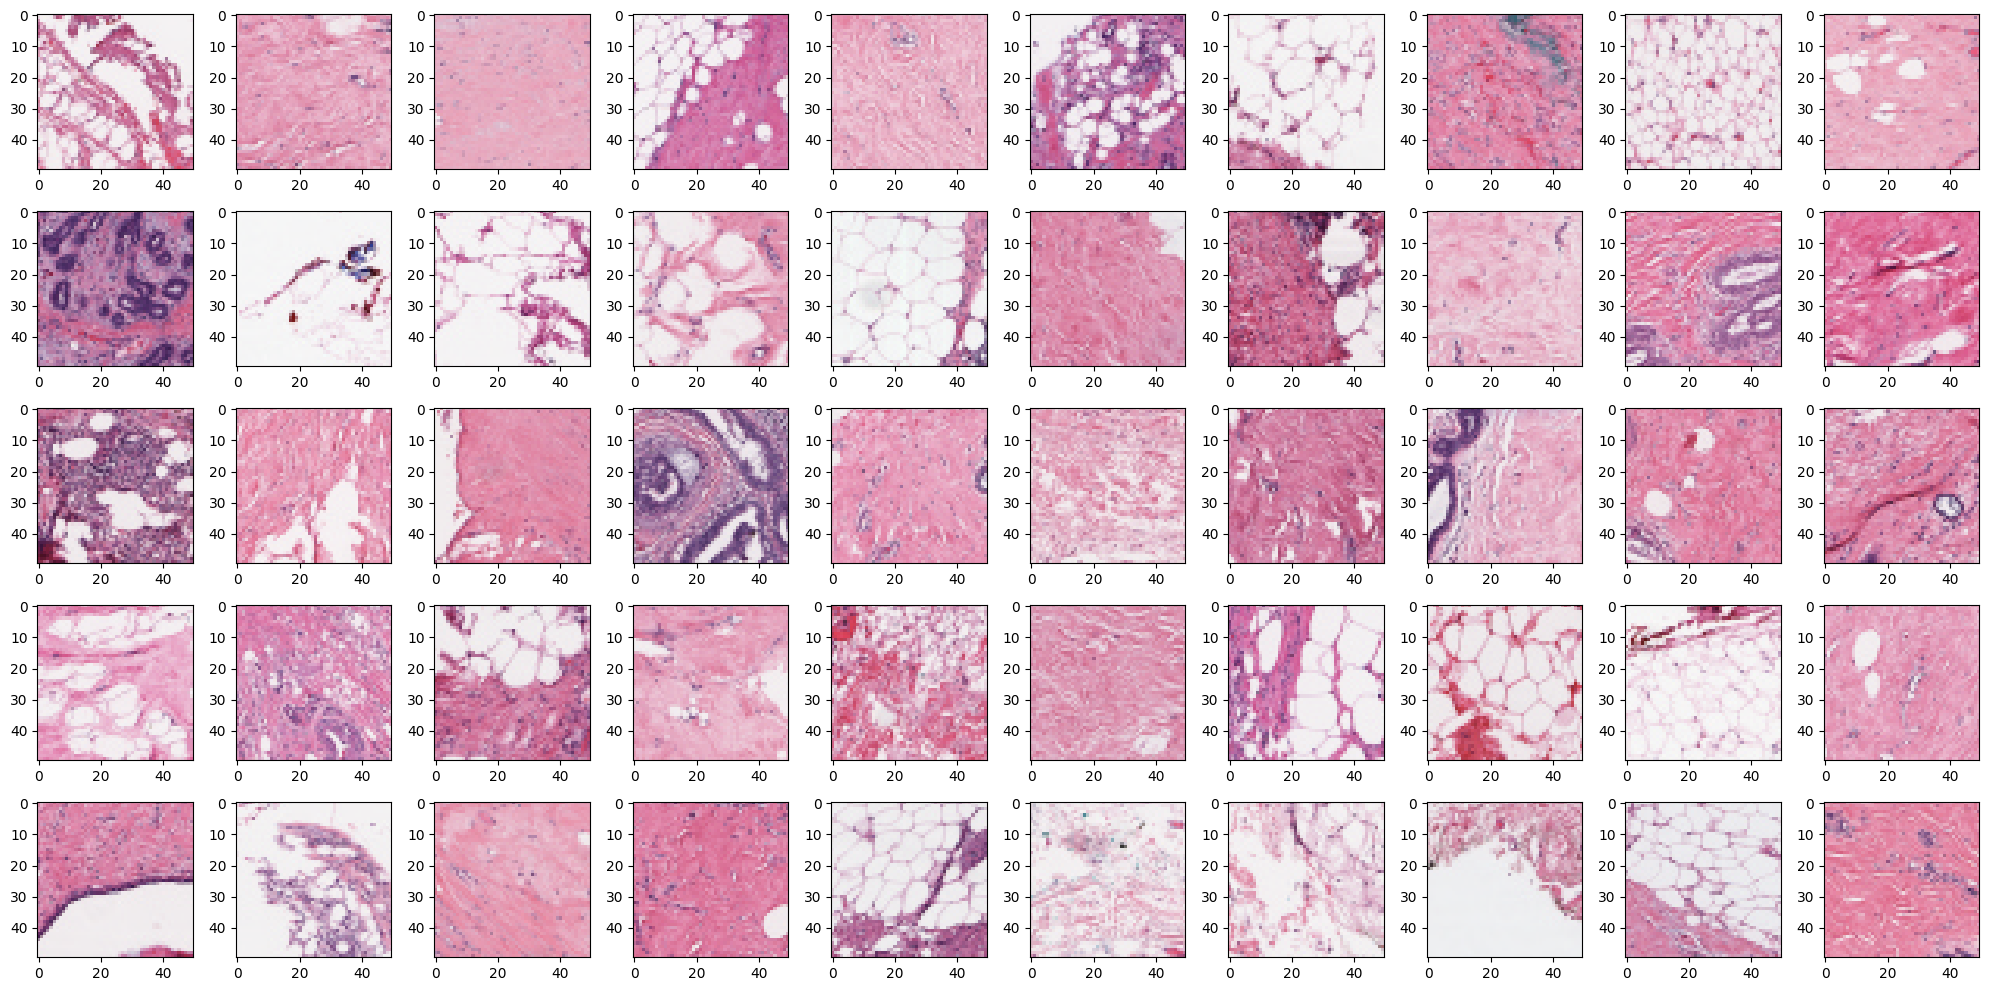

In [17]:
# Create a figure with subplots
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

# Loop through the subplots
for n in range(5):
    for m in range(10):
        # Calculate the index based on row and column
        idx = m + 10 * n

        if idx < len(BENIGNsample):
            # Open the image using PIL
            image = Image.open(BENIGNsample[idx])

            # Display the image on the current subplot
            ax[n, m].imshow(image)
            ax[n, m].grid(False)
        else:
            # If there are not enough images to fill the grid, remove the empty subplot
            fig.delaxes(ax[n, m])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of healthy patches
plt.show()

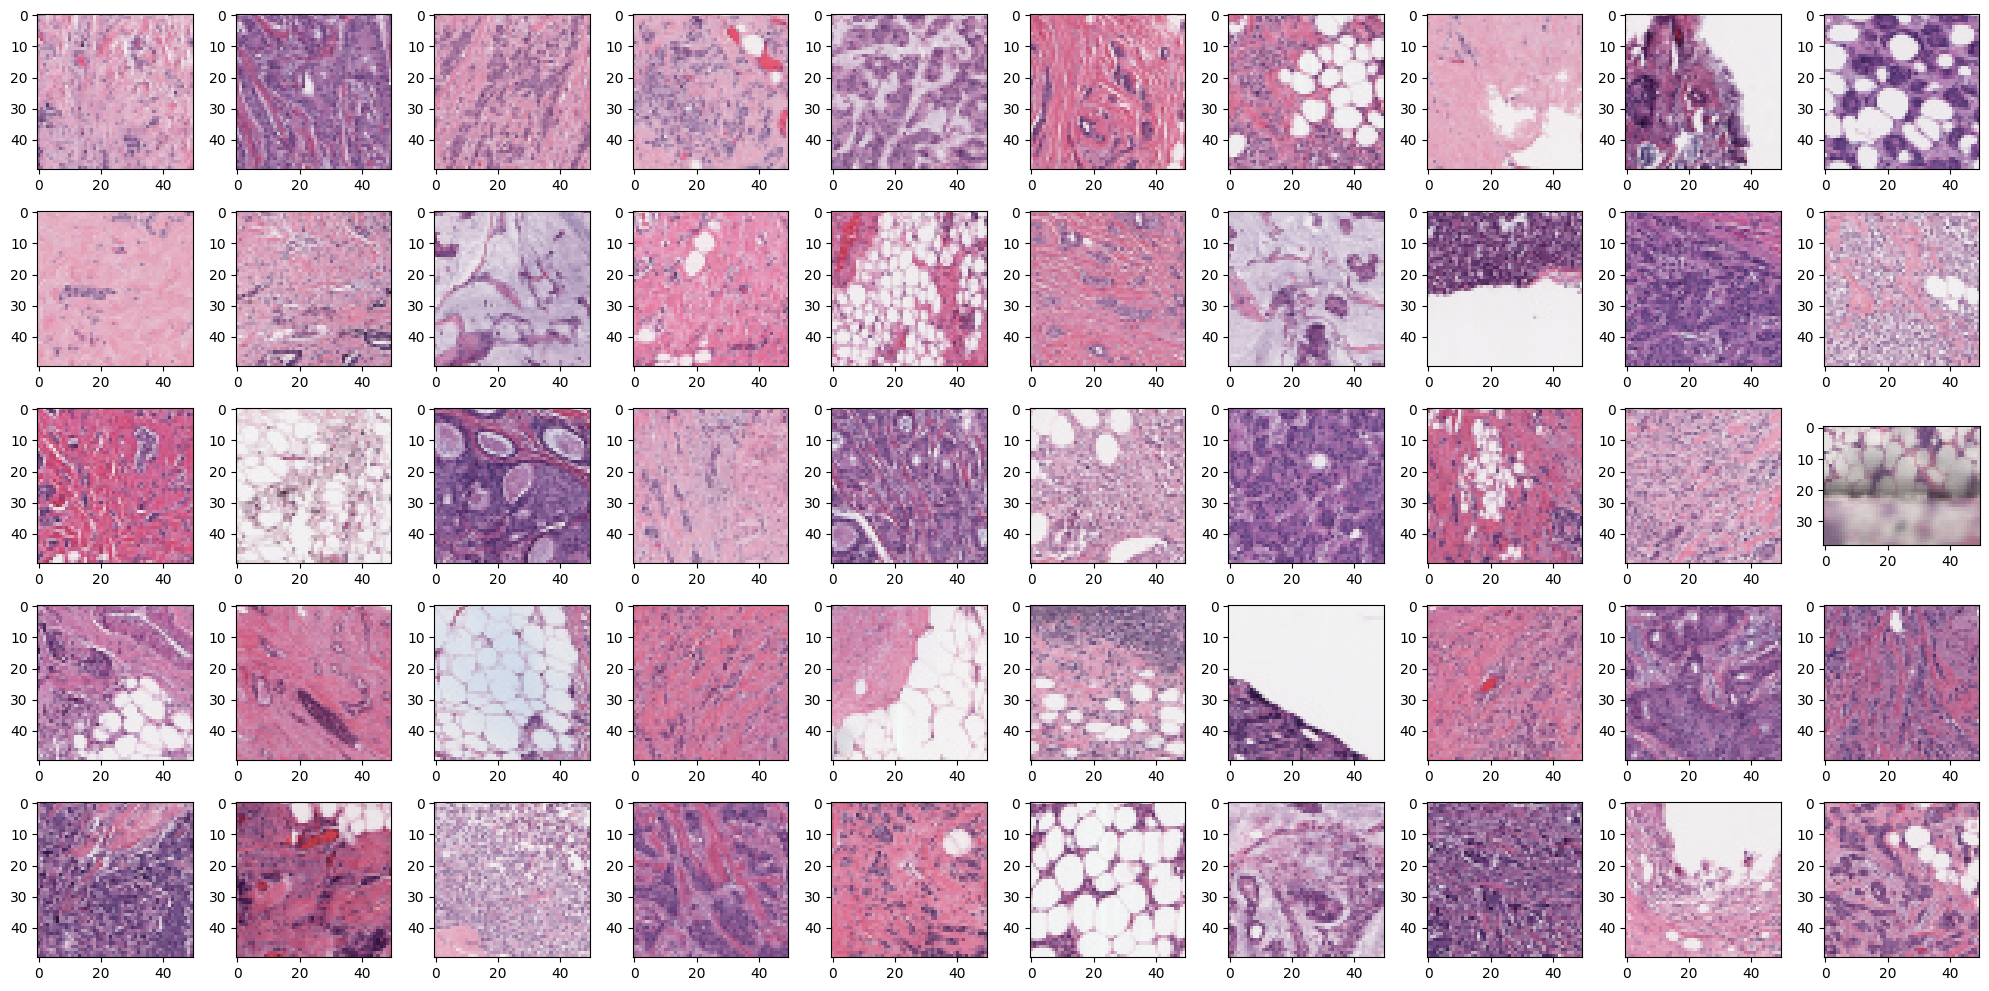

In [18]:
# Create a figure with subplots
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

# Loop through the subplots
for n in range(5):
    for m in range(10):
        # Calculate the index based on row and column
        idx = m + 10 * n

        if idx < len(MALIGNANTsample):
            # Open the image using PIL
            image = Image.open(MALIGNANTsample[idx])

            # Display the image on the current subplot
            ax[n, m].imshow(image)
            ax[n, m].grid(False)
        else:
            # If there are not enough images to fill the grid, remove the empty subplot
            fig.delaxes(ax[n, m])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of healthy patches
plt.show()

In [19]:
# Class distribution


labels = ["BENIGN", "MALIGNANT"]
counts = [len(BENIGNdata), len(MALIGNANTdata)]
colors = ["green", "orange"]

total_samples = sum(counts)
percentages = [(count / total_samples) * 100 for count in counts]

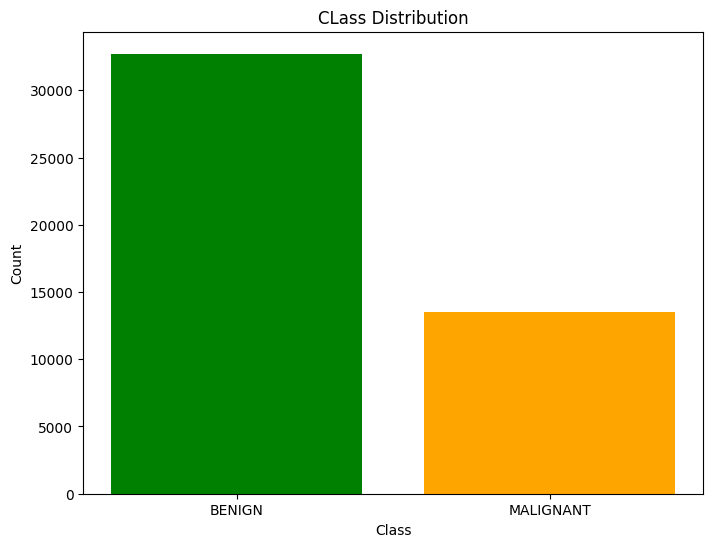

In [20]:
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=colors)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("CLass Distribution")
plt.show()

# Data Preprocessing

In [21]:
# Resizing the samples

target_size = (50, 50)
resizedBENIGN = []
resizedMALIGNANT = []

for image_path in BENIGNdata:
    image = Image.open(image_path)
    new_image = image.resize(target_size, Image.LANCZOS)  # Resize with anti-aliasing for better quality
    resizedBENIGN.append(new_image)

for image_path in MALIGNANTdata:
    image = Image.open(image_path)
    new_image = image.resize(target_size, Image.LANCZOS)  # Resize with anti-aliasing for better quality
    resizedMALIGNANT.append(new_image)

In [ ]:
# Normalize the dataset pixel values

BENIGNdataset = np.array([np.array(image) / 255.0 for image in resizedBENIGN])
MALIGNANTdataset = np.array([np.array(image) / 255.0 for image in resizedMALIGNANT])

In [ ]:
# Shuffle dataset

BENIGNdataset = shuffle(BENIGNdataset, random_state=42)
MALIGNANTdataset = shuffle(MALIGNANTdataset, random_state=42)

In [ ]:
# Shape of the dataset

print("BENIGNdataset shape: {}" .format(BENIGNdataset.shape))
print("MALIGNANTdataset shape: {}" .format(MALIGNANTdataset.shape))

In [ ]:
# Split the data

# Split into training and testing

BENIGNtrain, BENIGNtemp, BENIGNtrain_labels, BENIGNtemp_labels = train_test_split(
    BENIGNdataset, BENIGNlabels, test_size= 0.2, stratify= BENIGNlabels, random_state= 42
)

MALIGNANTtrain, MALIGNANTtemp, MALIGNANTtrain_labels, MALIGNANTtemp_labels = train_test_split(
    MALIGNANTdataset, MALIGNANTlabels, test_size= 0.2, stratify= MALIGNANTlabels, random_state= 42
)

# Split validation and test data

BENIGNval, BENIGNtest, BENIGNval_labels, BENIGNtest_labels = train_test_split(
    BENIGNtemp, BENIGNtemp_labels, test_size= 0.5, stratify= BENIGNtemp_labels, random_state= 42
)

MALIGNANTval, MALIGNANTtest, MALIGNANTval_labels, MALIGNANTtest_labels = train_test_split(
    MALIGNANTtemp, MALIGNANTtemp_labels, test_size= 0.5, stratify= MALIGNANTtemp_labels, random_state= 42
)


# Combine the couples into a one

train_data = np.concatenate((BENIGNtrain, MALIGNANTtrain), axis= 0)
train_labels = np.concatenate((BENIGNtrain_labels, MALIGNANTtrain_labels), axis= 0)
val_data = np.concatenate((BENIGNval, MALIGNANTval), axis= 0)
val_labels = np.concatenate((BENIGNval_labels, MALIGNANTval_labels), axis= 0)
test_data = np.concatenate((BENIGNtest, MALIGNANTtest), axis= 0)
test_labels = np.concatenate((BENIGNtest_labels, MALIGNANTtest_labels), axis= 0)

In [20]:
# Reformat the shape for the labels

train_labels = to_categorical(train_labels, 2)
val_labels = to_categorical(val_labels, 2)
test_labels = to_categorical(test_labels, 2)

In [21]:
print('train_data shape : {}' .format(train_data.shape))
print('train_labels shape : {}' .format(train_labels.shape))
print('val_data shape : {}' .format(val_data.shape))
print('val_labels shape : {}' .format(val_labels.shape))
print('test_data shape : {}' .format(test_data.shape))
print('test_labels shape : {}' .format(test_labels.shape))

train_data shape : (37003, 50, 50, 3)
train_labels shape : (37003, 2)
val_data shape : (4625, 50, 50, 3)
val_labels shape : (4625, 2)
test_data shape : (4626, 50, 50, 3)
test_labels shape : (4626, 2)


# Model Architecture

In [22]:
model = tf.keras.Sequential([
    # Convolution Layers
    tf.keras.layers.Conv2D(32, (3, 3), padding= "same", activation= "relu", input_shape= (50, 50, 3)),
    tf.keras.layers.MaxPooling2D(strides= 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding= "same", activation= "relu"),
    tf.keras.layers.MaxPooling2D((3, 3),strides = 2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((3, 3),strides =2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((3, 3),strides =2),

    # Flattern layer
    tf.keras.layers.Flatten(),

    # Fully Connected Layers
    tf.keras.layers.Dense(128, activation= "relu"),
    tf.keras.layers.Dense(2, activation = "softmax")
])


In [23]:
from tensorflow.keras.applications import ResNet50

base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(50,50,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in base_model.layers:
        layer.trainable=False


model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation= "relu"),
    tf.keras.layers.Dense(2, activation = "softmax")
])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model.compile(optimizer= opt, loss= "binary_crossentropy", metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=5,           # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

# Model training

In [ ]:
history = model.fit(train_data, train_labels, validation_data= (val_data, val_labels), epochs= 25, batch_size= 75, callbacks=[early_stopping])

In [32]:
model.evaluate(test_data, test_labels)

109/109 [==============================] - 1s 6ms/step - loss: 0.2979 - accuracy: 0.8795


[0.2979402244091034, 0.879538893699646]

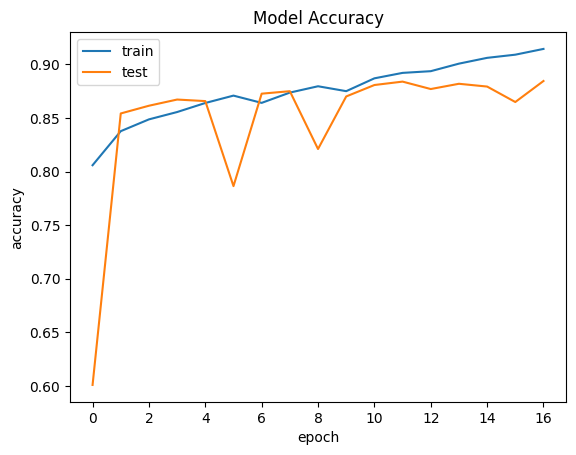

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

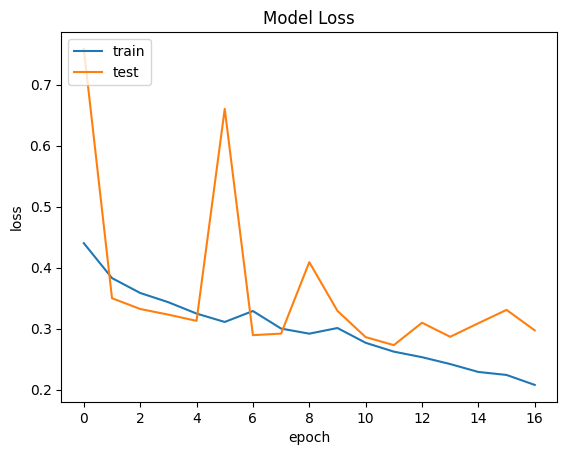

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
predict_data = model.predict(test_data)
predict_labels = np.argmax(predict_data, axis=1)

109/109 [==============================] - 0s 3ms/step


In [36]:
def convert_to_single_label(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1)

# Convert train_labels
true_train_labels = convert_to_single_label(train_labels)

# Convert val_labels
true_val_labels = convert_to_single_label(val_labels)

# Convert test_labels
true_test_labels = convert_to_single_label(test_labels)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_test_labels, predict_labels)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88
